# Timeseries classification with a Transformer model

**Author:** [Theodoros Ntakouris](https://github.com/ntakouris)<br>
**Date created:** 2021/06/25<br>
**Last modified:** 2021/08/05<br>
**Description:** This notebook demonstrates how to do timeseries classification using a Transformer model.

## Introduction

This is the Transformer architecture from
[Attention Is All You Need](https://arxiv.org/abs/1706.03762),
applied to timeseries instead of natural language.

This example requires TensorFlow 2.4 or higher.

## Load the dataset

We are going to use the same dataset and preprocessing as the
[TimeSeries Classification from Scratch](https://keras.io/examples/timeseries/timeseries_classification_from_scratch)
example.

In [1]:
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

2023-07-19 03:49:23.279843: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-19 03:49:23.423762: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
def readucr(filename):
    data = np.loadtxt(filename, delimiter="\t")
    y = data[:, 0]
    x = data[:, 1:]
    return x, y.astype(int)


root_url = "https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/"

x_train, y_train = readucr(root_url + "FordA_TRAIN.tsv")
x_test, y_test = readucr(root_url + "FordA_TEST.tsv")

x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

n_classes = len(np.unique(y_train))

idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

y_train[y_train == -1] = 0
y_test[y_test == -1] = 0

## Visualize the data

Here we visualize one timeseries example for each class in the dataset.

idx: 1700
    class 0 with c_x_train.shape (1846, 500, 1)
    class 1 with c_x_train.shape (1755, 500, 1)


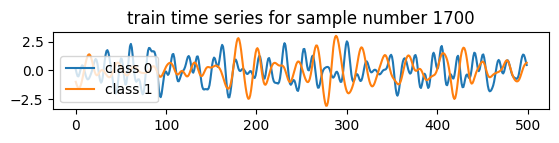

idx: 1701
    class 0 with c_x_train.shape (1846, 500, 1)
    class 1 with c_x_train.shape (1755, 500, 1)


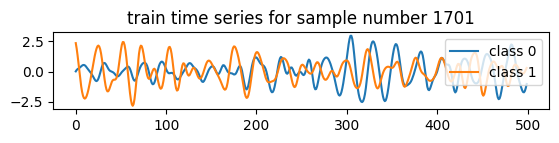

idx: 1702
    class 0 with c_x_train.shape (1846, 500, 1)
    class 1 with c_x_train.shape (1755, 500, 1)


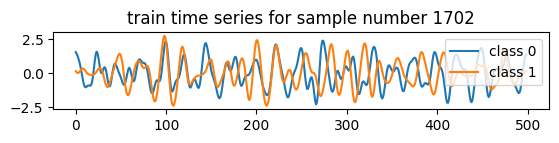

idx: 1703
    class 0 with c_x_train.shape (1846, 500, 1)
    class 1 with c_x_train.shape (1755, 500, 1)


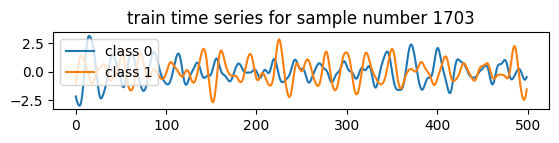

idx: 1704
    class 0 with c_x_train.shape (1846, 500, 1)
    class 1 with c_x_train.shape (1755, 500, 1)


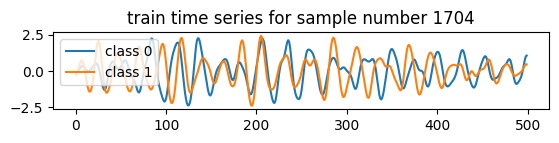

In [3]:
classes = np.unique(np.concatenate((y_train, y_test), axis=0))

start_sample_numbers=1700
end_interval=5

for idx in range(start_sample_numbers,start_sample_numbers+end_interval):
    print(f'idx: {idx}')    
    plt.figure().set_figheight(1)
    for c in classes:
        c_x_train = x_train[y_train == c]
        print(f'    class {c} with c_x_train.shape {c_x_train.shape}')
        plt.plot(c_x_train[idx], label="class " + str(c))


    plt.legend(loc="best")
    plt.title(f'train time series for sample number {idx}')
    plt.show()
    plt.close()
plt.close()

## Build the model

Our model processes a tensor of shape `(batch size, sequence length, features)`,
where `sequence length` is the number of time steps and `features` is each input
timeseries.

You can replace your classification RNN layers with this one: the
inputs are fully compatible!

We include residual connections, layer normalization, and dropout.
The resulting layer can be stacked multiple times.

The projection layers are implemented through `keras.layers.Conv1D`.

In [4]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res


The main part of our model is now complete. We can stack multiple of those
`transformer_encoder` blocks and we can also proceed to add the final
Multi-Layer Perceptron classification head. Apart from a stack of `Dense`
layers, we need to reduce the output tensor of the `TransformerEncoder` part of
our model down to a vector of features for each data point in the current
batch. A common way to achieve this is to use a pooling layer. For
this example, a `GlobalAveragePooling1D` layer is sufficient.

In [5]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
    ):
    
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(n_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)





## Setup model

2023-07-19 03:49:29.814619: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-19 03:49:29.849406: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-19 03:49:29.849640: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-19 03:49:29.851310: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 500, 1)]     0           []                               
                                                                                                  
 layer_normalization (LayerNorm  (None, 500, 1)      2           ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 multi_head_attention (MultiHea  (None, 500, 1)      7169        ['layer_normalization[0][0]',    
 dAttention)                                                      'layer_normalization[0][0]']    
                                                                                              

 mbda)                                                            'tf.__operators__.add_5[0][0]'] 
                                                                                                  
 layer_normalization_7 (LayerNo  (None, 500, 1)      2           ['tf.__operators__.add_6[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv1d_6 (Conv1D)              (None, 500, 4)       8           ['layer_normalization_7[0][0]']  
                                                                                                  
 dropout_7 (Dropout)            (None, 500, 4)       0           ['conv1d_6[0][0]']               
                                                                                                  
 conv1d_7 (Conv1D)              (None, 500, 1)       5           ['dropout_7[0][0]']              
          

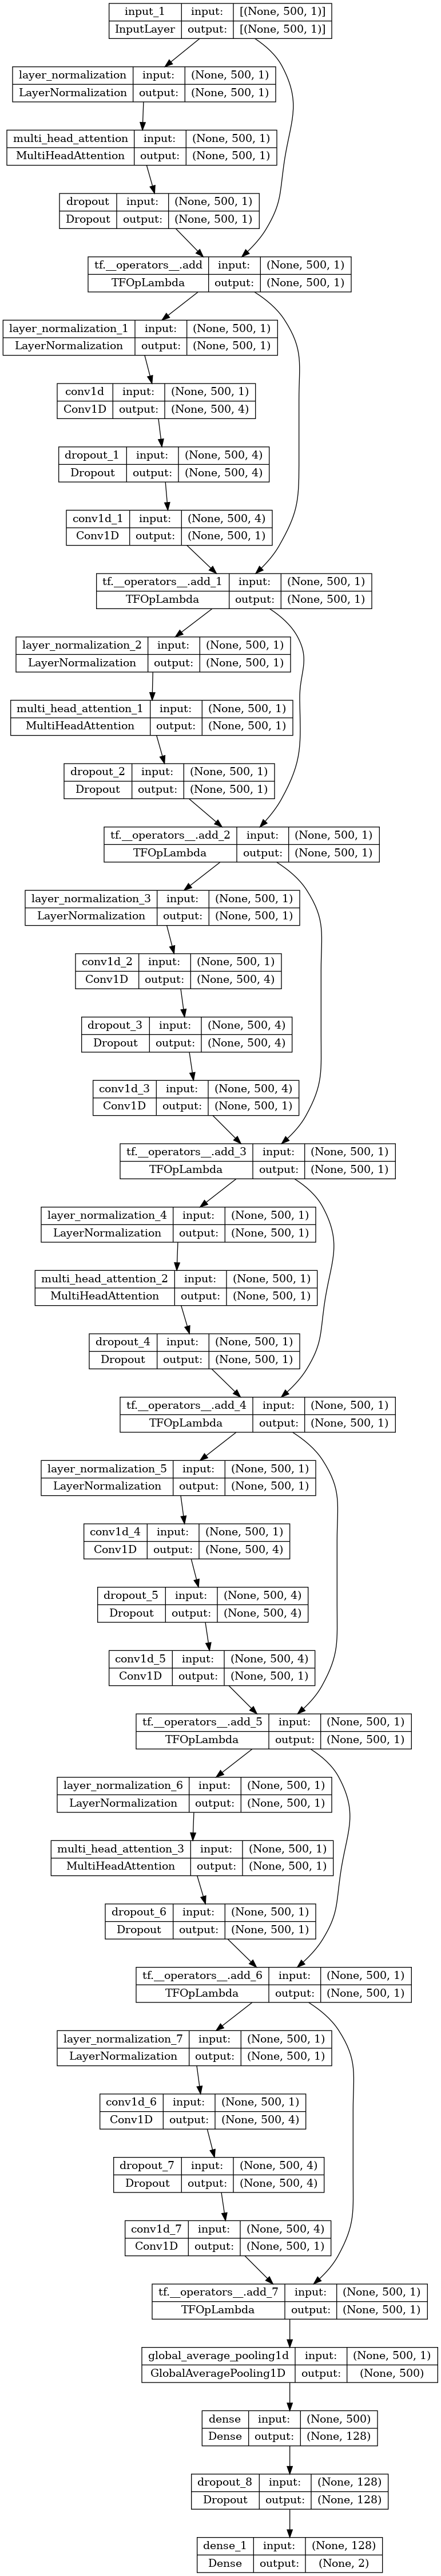

In [6]:
input_shape = x_train.shape[1:]

# epoch_number = 2
# epoch_number = 10
# epoch_number = 50
epoch_number = 100
# epoch_number = 200
# epoch_number = 300
# epoch_number = 500

# batch_size = 16
# batch_size = 32
batch_size = 64



# RESOURCE_EXHAUSTED: OOM when allocating tensor with shape[64,500,4,256] and 
#     type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
# SOLUTION > Change batch size https://github.com/tensorflow/models/issues/8487                        



model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["sparse_categorical_accuracy"],
)
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("best_transforer_model.h5", save_best_only=True, monitor="val_loss"),
    keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
]


# callbacks = [
#     keras.callbacks.ReduceLROnPlateau(
#         monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
#     ),
#     keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
# ]



print(f'input_shape: {input_shape}')
keras.utils.plot_model(model, show_shapes=True)



## Train the model

In [7]:
history = model.fit(
    x_train,
    y_train,
    validation_split=0.2,
    epochs=epoch_number,
    batch_size=batch_size,
    callbacks=callbacks,
)


Epoch 1/100


2023-07-19 03:49:38.359861: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-07-19 03:49:38.667316: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8800
2023-07-19 03:49:39.872209: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f36335dcce0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-19 03:49:39.872236: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA RTX A2000 8GB Laptop GPU, Compute Capability 8.6
2023-07-19 03:49:39.876745: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-19 03:49:40.002289: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the life

45/45 [==============================] - 36s 509ms/step - loss: 1.0313 - sparse_categorical_accuracy: 0.5066 - val_loss: 0.7235 - val_sparse_categorical_accuracy: 0.5881
Epoch 2/100
45/45 [==============================] - 23s 503ms/step - loss: 0.8661 - sparse_categorical_accuracy: 0.5503 - val_loss: 0.6582 - val_sparse_categorical_accuracy: 0.6560
Epoch 3/100
45/45 [==============================] - 23s 504ms/step - loss: 0.7891 - sparse_categorical_accuracy: 0.5889 - val_loss: 0.6202 - val_sparse_categorical_accuracy: 0.6741
Epoch 4/100
45/45 [==============================] - 23s 503ms/step - loss: 0.7292 - sparse_categorical_accuracy: 0.6226 - val_loss: 0.5874 - val_sparse_categorical_accuracy: 0.6865
Epoch 5/100
45/45 [==============================] - 23s 503ms/step - loss: 0.6894 - sparse_categorical_accuracy: 0.6351 - val_loss: 0.5804 - val_sparse_categorical_accuracy: 0.7143
Epoch 6/100
45/45 [==============================] - 23s 503ms/step - loss: 0.6488 - sparse_categorica

Epoch 46/100
45/45 [==============================] - 23s 502ms/step - loss: 0.3052 - sparse_categorical_accuracy: 0.8792 - val_loss: 0.4374 - val_sparse_categorical_accuracy: 0.8141
Epoch 47/100
45/45 [==============================] - 23s 502ms/step - loss: 0.2906 - sparse_categorical_accuracy: 0.8948 - val_loss: 0.4339 - val_sparse_categorical_accuracy: 0.8114
Epoch 48/100
45/45 [==============================] - 22s 501ms/step - loss: 0.2968 - sparse_categorical_accuracy: 0.8910 - val_loss: 0.4337 - val_sparse_categorical_accuracy: 0.8141
Epoch 49/100
45/45 [==============================] - 22s 499ms/step - loss: 0.2927 - sparse_categorical_accuracy: 0.8986 - val_loss: 0.4367 - val_sparse_categorical_accuracy: 0.8128
Epoch 50/100
45/45 [==============================] - 23s 502ms/step - loss: 0.2854 - sparse_categorical_accuracy: 0.8948 - val_loss: 0.4303 - val_sparse_categorical_accuracy: 0.8225
Epoch 51/100
45/45 [==============================] - 22s 498ms/step - loss: 0.2839 -

Epoch 91/100
45/45 [==============================] - 22s 501ms/step - loss: 0.1888 - sparse_categorical_accuracy: 0.9309 - val_loss: 0.3963 - val_sparse_categorical_accuracy: 0.8308
Epoch 92/100
45/45 [==============================] - 22s 499ms/step - loss: 0.1857 - sparse_categorical_accuracy: 0.9354 - val_loss: 0.3971 - val_sparse_categorical_accuracy: 0.8363
Epoch 93/100
45/45 [==============================] - 22s 500ms/step - loss: 0.1828 - sparse_categorical_accuracy: 0.9365 - val_loss: 0.3934 - val_sparse_categorical_accuracy: 0.8363
Epoch 94/100
45/45 [==============================] - 23s 503ms/step - loss: 0.1761 - sparse_categorical_accuracy: 0.9424 - val_loss: 0.3921 - val_sparse_categorical_accuracy: 0.8336
Epoch 95/100
45/45 [==============================] - 22s 499ms/step - loss: 0.1747 - sparse_categorical_accuracy: 0.9458 - val_loss: 0.3932 - val_sparse_categorical_accuracy: 0.8294
Epoch 96/100
45/45 [==============================] - 22s 500ms/step - loss: 0.1775 -

## Evaluate model on test data

In [8]:
model = keras.models.load_model("best_transforer_model.h5")
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=1)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

42/42 [==============================] - 4s 84ms/step - loss: 0.3526 - sparse_categorical_accuracy: 0.8462
Test accuracy 0.8462121486663818
Test loss 0.35256874561309814


## Plot the model's training and validation loss

history.params: {'verbose': 1, 'epochs': 100, 'steps': 45}
history.history.keys(): dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


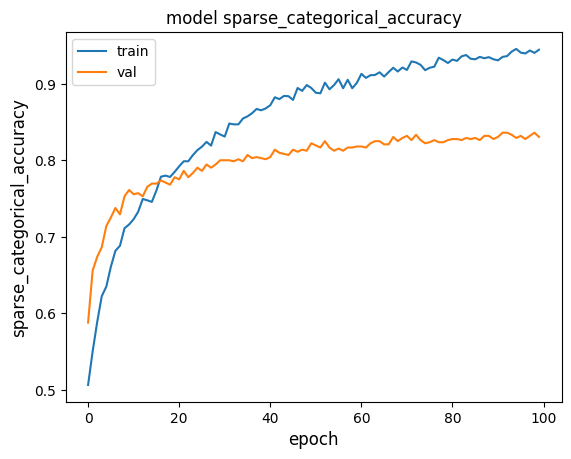

In [9]:
metric = "sparse_categorical_accuracy"


print(f'history.params: {history.params}' )
print(f'history.history.keys(): {history.history.keys()}')

plt.figure()

plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.plot(history.history['lr'])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()




## Conclusions

In about 110-120 epochs (25s each on Colab), the model reaches a training
accuracy of ~0.95, validation accuracy of ~84 and a testing
accuracy of ~85, without hyperparameter tuning. And that is for a model
with less than 100k parameters. Of course, parameter count and accuracy could be
improved by a hyperparameter search and a more sophisticated learning rate
schedule, or a different optimizer.

You can use the trained model hosted on [Hugging Face Hub](https://huggingface.co/keras-io/timeseries_transformer_classification) and try the demo on [Hugging Face Spaces](https://huggingface.co/spaces/keras-io/timeseries_transformer_classification).